In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from utils_ab import *

sns.set_theme(font_scale=1.5, palette='Set2')
sns.set_style("whitegrid")




## Goal: To Demonstrate the effect of treatment effect exaggeration for underpowered experiments

Let's say we conducted an experiment and obtained a statistically significant result. Can we trust it? The answer lies in the statistical power of our experiment, which is determined by the minimum detectable effect and sample size. To illustrate this relationship, let's visualize power as a function of sample size for a fixed treatment effect.

0.05500000000000001
31217.42343077759


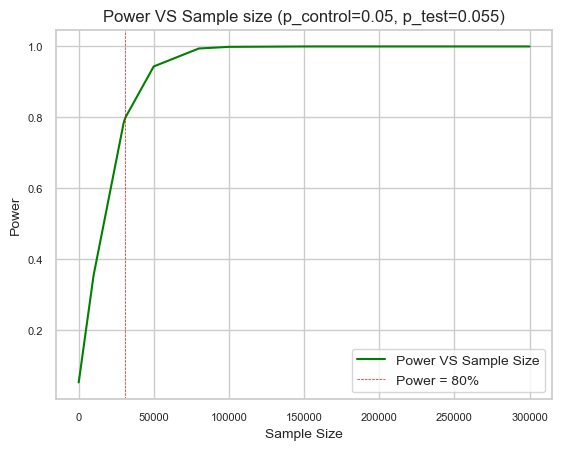

In [13]:
lift = 0.1
p_control = 0.05
p_test = p_control*(1+lift)
print(p_test)
sample_size_p80 = calculate_sample_size(p1=p_control, p2=p_test, alpha=0.05, power=0.8)
print(sample_size_p80)
sample_sizes = [100, 1000, 5000, 10000, 30000, 50000, 80000, 100000, 150000, 300000]
sample_sizes.append(sample_size_p80)

powers = []
for s in sample_sizes:
    p = calculate_power(p1=p_control, p2=p_test, alpha=0.05, sample_size=s)
    powers.append(p)

df_power = pd.DataFrame({'sample_size': sample_sizes, 'power': powers})

sns.lineplot(x='sample_size', y='power', data=df_power, color='green', label='Power VS Sample Size')
plt.axvline(x=sample_size_p80, color='red', ls='--', lw=0.5, label='Power = 80%')
plt.title(f'Power VS Sample size (p_control={np.round(p_control,4)}, p_test={np.round(p_test,4)})', fontsize=12)
plt.xlabel('Sample Size', fontsize=10)
plt.ylabel('Power', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=10, loc='lower right')
plt.show()


This plot shows that when we aim to detect a particular effect but the sample size is insufficient (in this case, less than ~30,000, corresponding to the industry standard of 80% power), it results in lower power. As a consequence, as demonstrated below, with lower power increases the probability of obtaining a statistically significant result with an inflated value of the target metric and increased variability. This effect is proportional to the degree of underpowering in our experiment—a well-known issue of obtaining unrealistically high metrics in experiments with a small user base.

This notebook is based on this paper https://docs.google.com/spreadsheets/d/1TFTflh8fPscuM2y7xTCleYJ_3CUfVyvQfENKN2W397w/edit?gid=453181582#gid=453181582 and created for my personal better understanding of the phenomenon.

Also this phenomenon is the cause of the well known p-value peeking or p-hacking problem mentioned here: https://www.evanmiller.org/how-not-to-run-an-ab-test.html. 

Other related sources:
https://guessthetest.com/the-winners-curse-the-big-problem-with-enormous-winners-in-a-b-testing/
A/B Testing Intuition Busters. Common Misunderstandings in Online Controlled Experiments. Ron Kohavi. (https://bit.ly/ABTestingIntuitionBusters)

### Simulation 1: 1000 A/B test, no lift, 100000 users in each 


Power:  0.05
Summaries: 
N users per variant:  100000
N simulations:  1000
CR per control:  0.05
CR per test:  0.05
----------
N simulations with stat sign lift:  0.048
Max stat sign lift:  0.073
Min stat sign lift:  0.039
Avg stat sign lift:  0.045


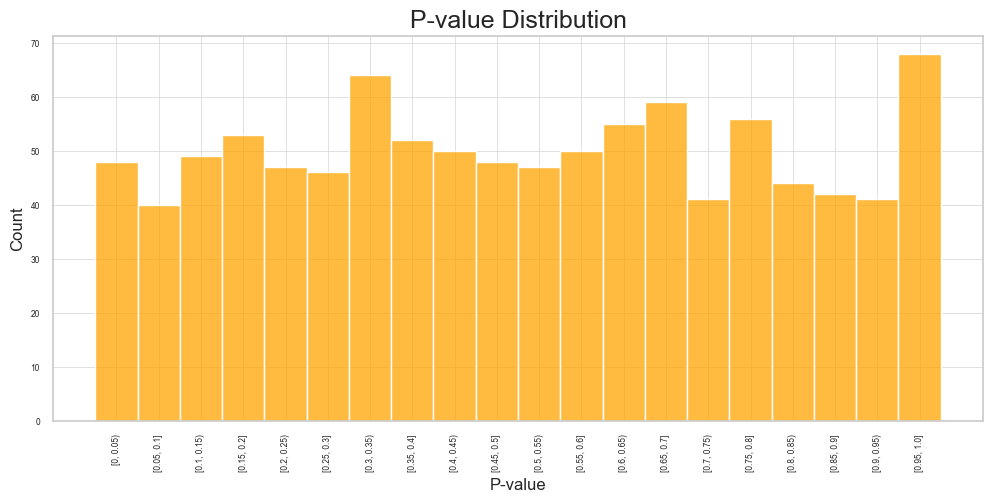

/Users/andreikristov/Documents/repos/ml_projects/AB Testing - Low Power Problem (stat)/utils_ab.py:128: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  #sns.kdeplot(x=result_df['mean_control'])


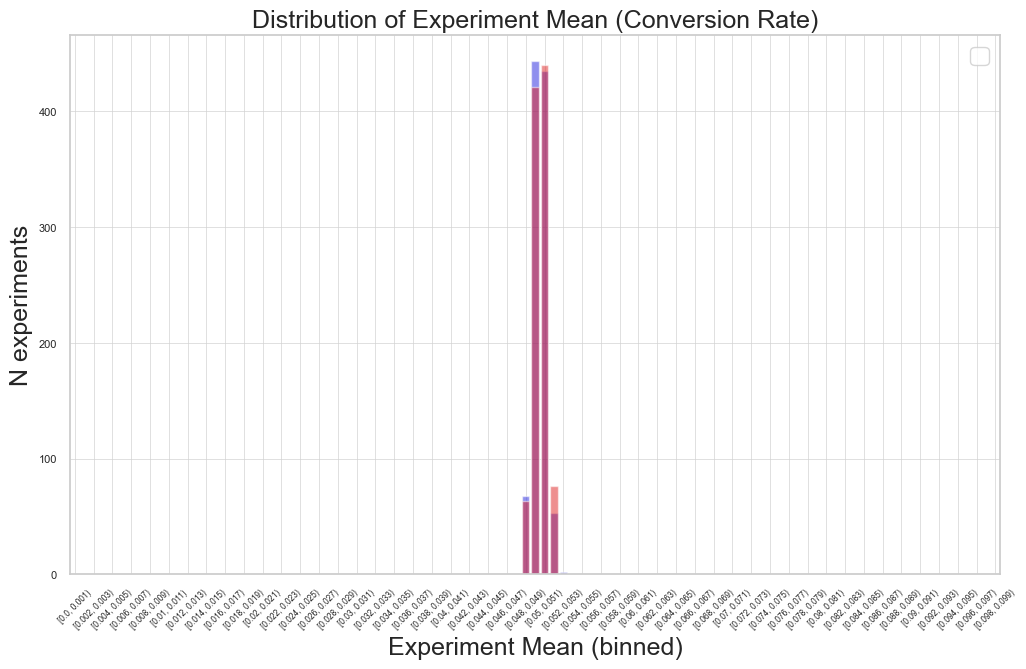

In [14]:

n_distributions = 1000
n_users = 100000
lift = 0.0
p_control = 0.05
p_test = p_control*(1+lift)
np.random.seed(0)

power = calculate_power(p1=p_control, p2=p_test, alpha=0.05, sample_size=n_users)
print('Power: ', np.round(power,3))

run_simulation(p1=p_control, p2=p_test, n_users=n_users, n_distributions=n_distributions)

As expected, when the Null hypothesis of no difference is true (as in this case), the p-value distribution should be approximately uniform, and it is.
Note that 0.48% of the time, the p-value was < 0.05, close to the 5% expected rate.
When it is a false positive (stat significant, p-value<=0.05), the absolute value of the lift was between 3.9% to 7.3% and the average was 4.5% (remeber, there is no lift actually).
Without the absolute value, the average lift is 0.3%, close to the zero you expect.
This is a small version of the winner’s curse, as we’re overestimating the lift

### Simulation 2: 1000 A/B test, lift 10%, 100000 users in each 


Now let’s look at an example where the treatment converts better at 5.5%, or 10% lift.
The power formula tells us that to detect a 10% delta, we need 30,400 users in each variant.
With 100,000 users, we have more than enough users (which is not bad, we could perform interesting drill-downs, but
that’s for another note). What happens in this case is that all 1,000 trials show Statistically significant results.

N users to reach 80% power:  31217
Summaries: 
N users per variant:  100000
N simulations:  1000
CR per control:  0.05
CR per tedt:  0.05500000000000001
----------
N simulations with stat sign lift:  0.999
Max stat sign lift:  0.164
Min stat sign lift:  0.038
Avg stat sign lift:  0.102


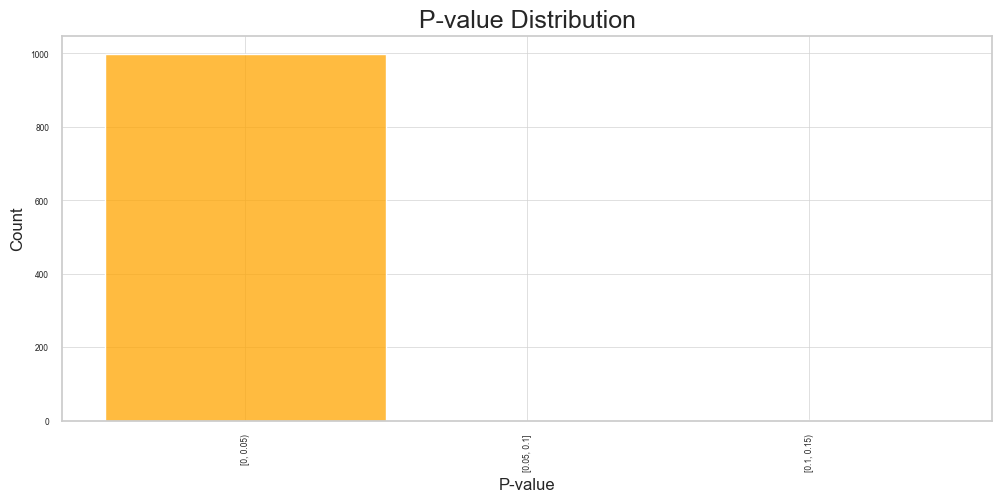

/var/folders/cj/fzhjw_nx32q2sxr47_780dtw0000gn/T/ipykernel_64984/3496604241.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().get_frame().set_facecolor('white')


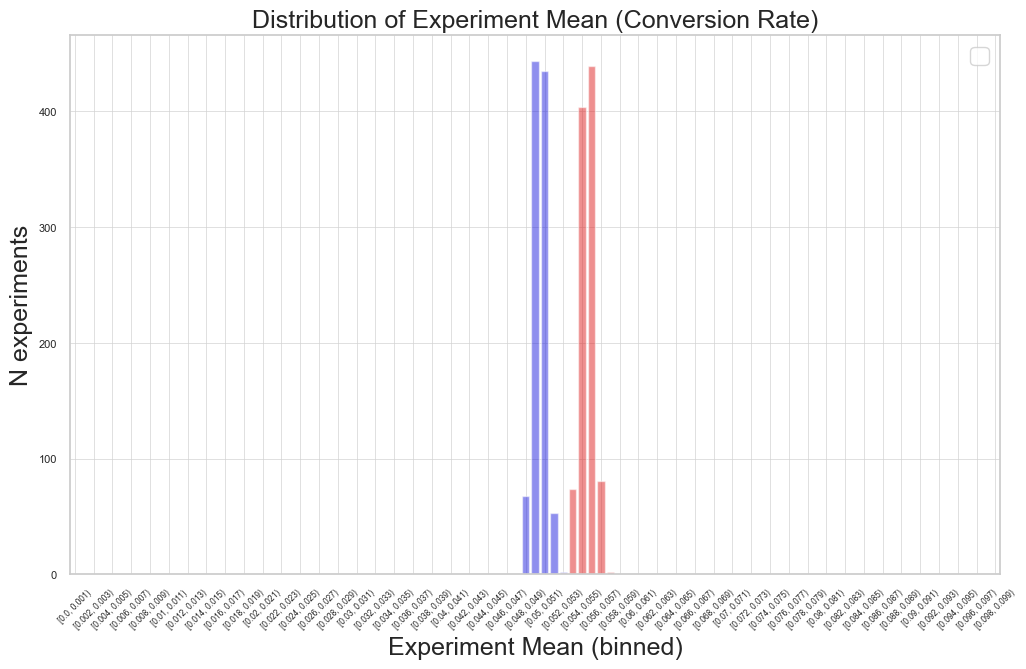

In [18]:
n_distributions = 1000
n_users = 100000
lift = 0.1
p_control = 0.05
p_test = p_control*(1+lift)
np.random.seed(0)

n_users_required_p80 = calculate_sample_size(p1=p_control, p2=p_test, alpha=0.05, power=0.8)
print('N users to reach 80% power: ', int(n_users_required_p80))

run_simulation(p1=p_control, p2=p_test, n_users=n_users, n_distributions=n_distributions)

The average lift is 10.2%, but you can see the variability: 3.8% to 16.4%.

### Simulation 3: 1000 A/B test, lift 10%, 30400 users in each (power=80%) 

Now let’s look at 30,400 users in each variant, which is the number the statistical power formula recommends for 80%
power. The distribution of the 1,000 trials is as follows:

Power:  0.79
Summaries: 
N users per variant:  30400
N simulations:  1000
CR per control:  0.05
CR per test:  0.055
----------
N simulations with stat sign lift:  0.782
Max stat sign lift:  0.229
Min stat sign lift:  0.069
Avg stat sign lift:  0.114


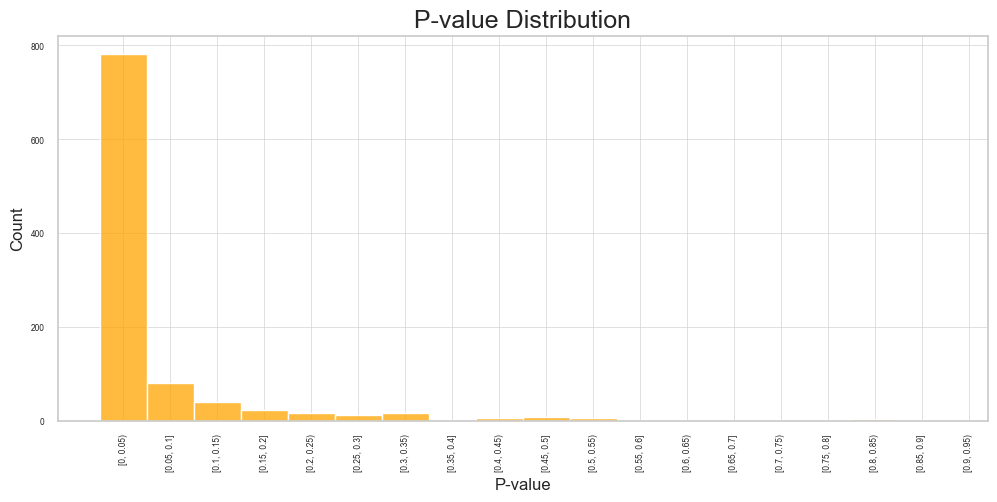

/var/folders/cj/fzhjw_nx32q2sxr47_780dtw0000gn/T/ipykernel_64984/2683159100.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().get_frame().set_facecolor('white')


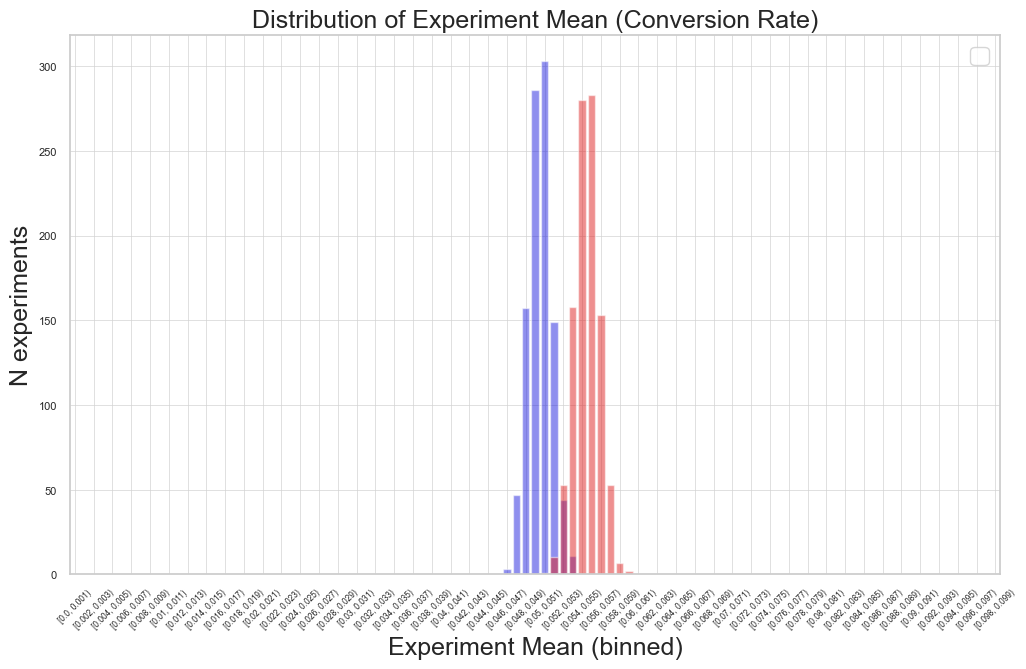

In [25]:
n_distributions = 1000
n_users = 30400
lift = 0.1
p_control = 0.05
p_test = p_control*(1+lift)
np.random.seed(0)

power = calculate_power(p1=p_control, p2=p_test, alpha=0.05, sample_size=n_users)
print('Power: ', np.round(power,3))

run_simulation(p1=p_control, p2=p_test, n_users=n_users, n_distributions=n_distributions)

78.2% of the time, very close to the 80%, we get statistically significant results.
When the results are stat-sig, we over-estimate the lift: 11.4% on average, which a range of 6.9% to 22.9%.

### Simulation 4: 1000 A/B test, lift 10%, 5000 users in each 

Now let’s look at a low power experiment with 5,000 users instead of 30,400 users.

Power:  0.202
Summaries: 
N users per variant:  5000
N simulations:  1000
CR per control:  0.05
CR per test:  0.055
----------
N simulations with stat sign lift:  0.19
Max stat sign lift:  0.396
Min stat sign lift:  0.159
Avg stat sign lift:  0.242


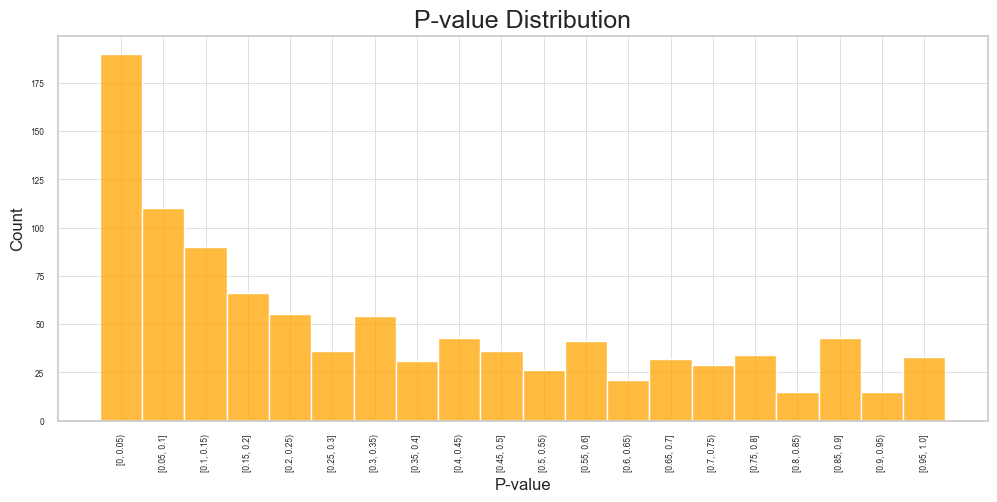

/var/folders/cj/fzhjw_nx32q2sxr47_780dtw0000gn/T/ipykernel_64984/2683159100.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().get_frame().set_facecolor('white')


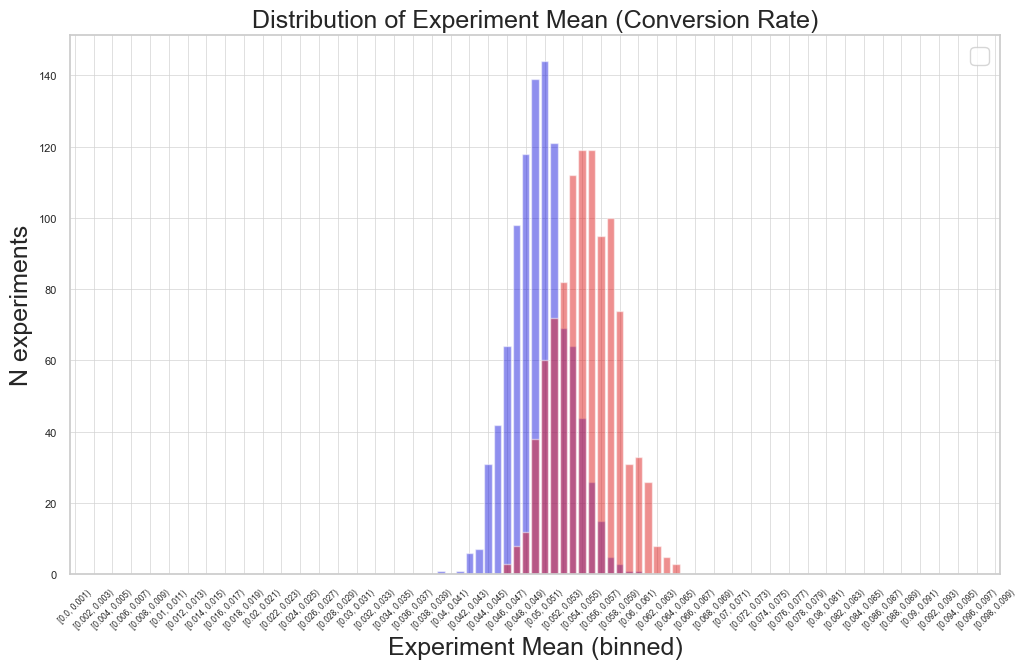

In [28]:
n_distributions = 1000
n_users = 5000
lift = 0.1
p_control = 0.05
p_test = p_control*(1+lift)
np.random.seed(0)

power = calculate_power(p1=p_control, p2=p_test, alpha=0.05, sample_size=n_users)
print('Power: ', np.round(power,3))

run_simulation(p1=p_control, p2=p_test, n_users=n_users, n_distributions=n_distributions)

What you see is that you get a statistically significant result only 19.0% of the time.
When it is stat-sig, you start suffering from the winner’s curse: you estimate that the lift is 24.2% on average, and ranges
from 15.9% to 39.6%, much higher than the actual 10% lift.

### Simulation 5: 1000 A/B test, lift 10%, 1000 users in each 

Let’s lower the power even more with 1,000 users.

Power:  0.079
Summaries: 
N users per variant:  1000
N simulations:  1000
CR per control:  0.05
CR per test:  0.055
----------
N simulations with stat sign lift:  0.081
Max stat sign lift:  1.1
Min stat sign lift:  0.328
Avg stat sign lift:  0.573


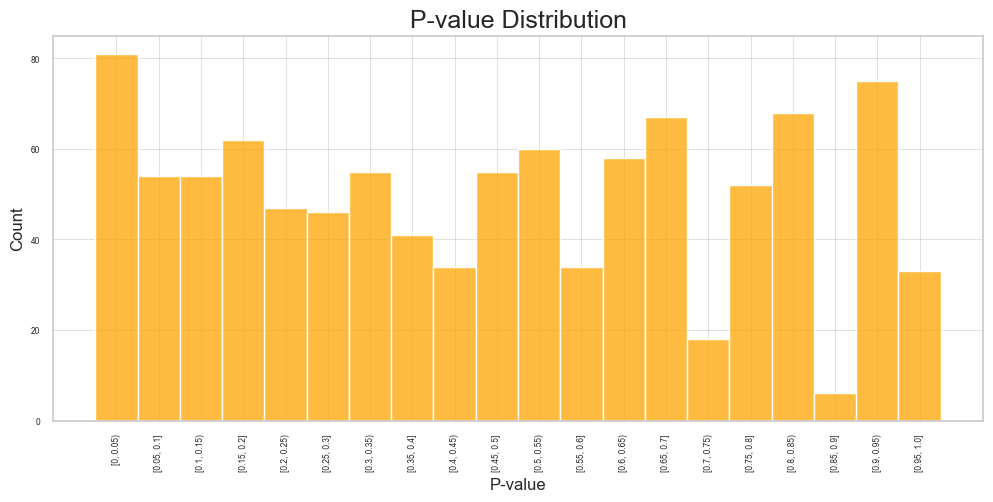

/var/folders/cj/fzhjw_nx32q2sxr47_780dtw0000gn/T/ipykernel_64984/2683159100.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().get_frame().set_facecolor('white')


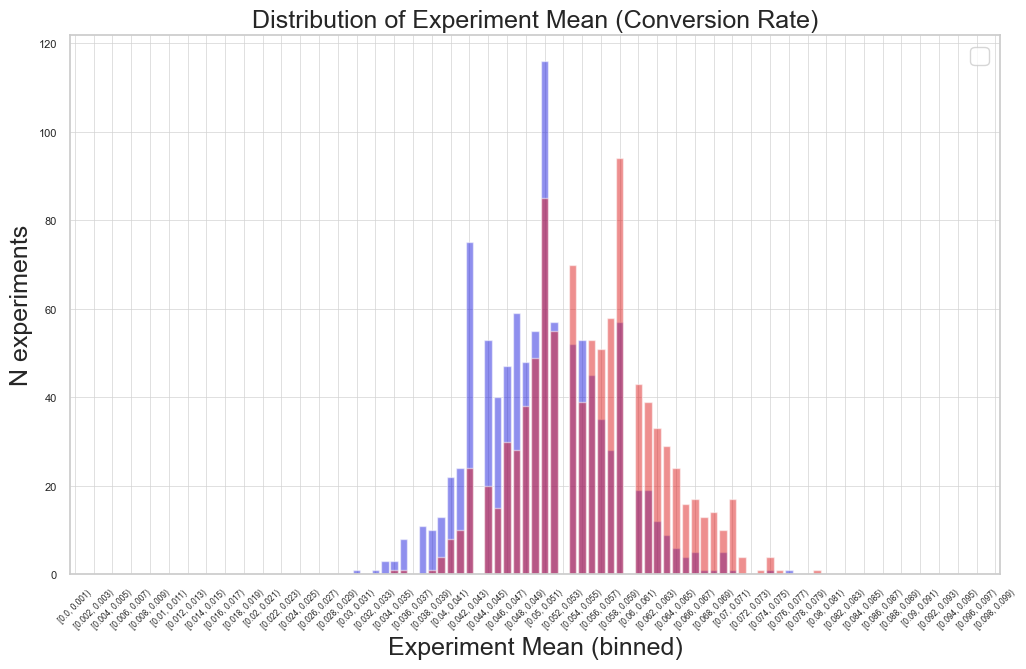

In [29]:
n_distributions = 1000
n_users = 1000
lift = 0.1
p_control = 0.05
p_test = p_control*(1+lift)
np.random.seed(0)

power = calculate_power(p1=p_control, p2=p_test, alpha=0.05, sample_size=n_users)
print('Power: ', np.round(power,3))

run_simulation(p1=p_control, p2=p_test, n_users=n_users, n_distributions=n_distributions)

Our chances of finding a statistically significant result are now just 8.1%.
When we do, we will dramatically over-estimate the lift at an average of 57.3%, ranging from 32.8% to 110.0%.

### Simulation 6: 1000 A/B test, lift 10%, 1000 users in each 

Finally, let’s look at very low power: 80 visitors, similar to the this example, which was mentioned in the paper (http://bit.ly/ABTestingIntuitionBusters).

Power:  0.052
Summaries: 
N users per variant:  80
N simulations:  1000
CR per control:  0.05
CR per test:  0.055
----------
N simulations with stat sign lift:  0.051
Max stat sign lift:  inf
Min stat sign lift:  0.667
Avg stat sign lift:  inf


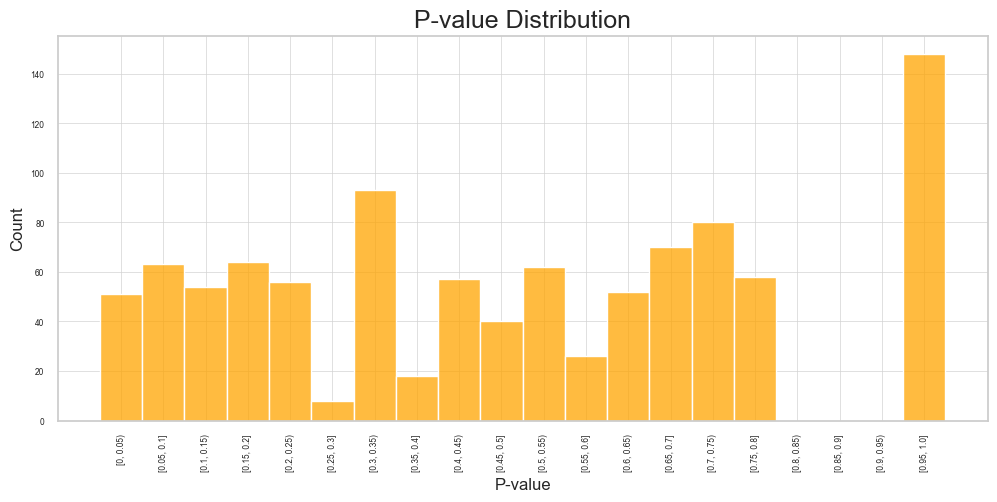

/var/folders/cj/fzhjw_nx32q2sxr47_780dtw0000gn/T/ipykernel_64984/2683159100.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().get_frame().set_facecolor('white')


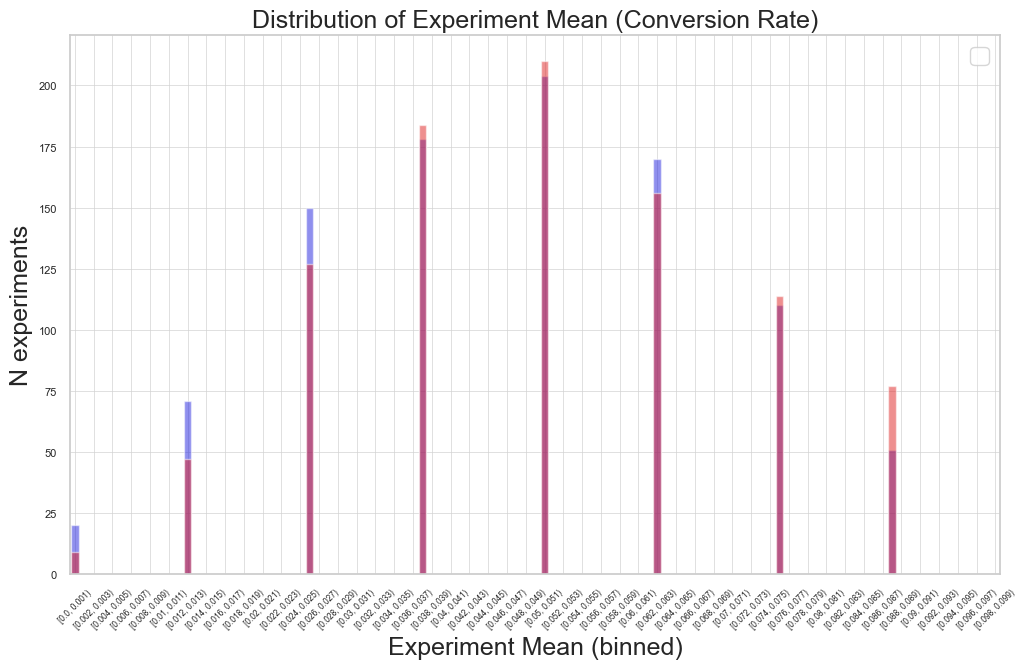

In [30]:
n_distributions = 1000
n_users = 80
lift = 0.1
p_control = 0.05
p_test = p_control*(1+lift)
np.random.seed(0)

power = calculate_power(p1=p_control, p2=p_test, alpha=0.05, sample_size=n_users)
print('Power: ', np.round(power,3))

run_simulation(p1=p_control, p2=p_test, n_users=n_users, n_distributions=n_distributions)

We see that we get stat-sig results 5.1% of the time, that is, basically the same as the 5% expected if there was no
difference. When the results are statistically significant, our average lift is inf, and ranges from 66.7% to inf. The lift is highly
inflated.